# 🔄 Agent Workflows with Microsoft Agent Framework (Python)

## 📋 What You'll Learn

This notebook shows you how to create multi-agent workflows where multiple AI agents work together in sequence. You'll build a simple travel recommendation workflow with two agents: a front desk agent and a reviewer agent.

**What's Inside:**
- 🏗️ **Workflow Builder**: Chain multiple agents together
- 📊 **Workflow Visualization**: See your workflow as a diagram
- 🔄 **Event-Driven Execution**: Process workflow results step by step
- 🤝 **Multi-Agent Coordination**: Agents reviewing each other's work

## ⚙️ Setup Requirements

### 1. **Docker & Dev Container**
- Install Docker on your machine
- Open this project in the dev container (VS Code will prompt you)

### 2. **Workspace Configuration**
- Open the workspace: `File > Open Workspace from File` → select `workspace.code-workspace`
- This sets up the correct Python environment for each project folder

### 3. **Environment Variables**
1. Copy `.env.example` to `.env` in the `agent-framework-samples` folder:
   ```bash
   cp .env.example .env
   ```
2. Fill in your Azure credentials:
   ```env
   # Azure OpenAI (Required for this example)
   AZURE_OPENAI_ENDPOINT=your_endpoint
   AZURE_OPENAI_CHAT_DEPLOYMENT_NAME=your_deployment
   ```

### 4. **System Dependencies**
The notebook will install graphviz automatically for workflow visualization.

## 🚀 What You'll Build

A simple workflow with two agents:

```
User Request → Front Desk Agent → Reviewer Agent → Final Response
```

1. **Front Desk Agent**: Provides travel recommendations
2. **Reviewer Agent**: Reviews and validates the recommendations

You'll see:
- How to define agent instructions
- How to connect agents in a workflow
- How to visualize the workflow structure
- How to run the workflow and process results

Let's build a collaborative agent workflow! 🌟

In [ ]:
from dotenv import load_dotenv 
from azure.identity import DefaultAzureCredential
from agent_framework.azure import AzureOpenAIChatClient
from pydantic import BaseModel
import os
import base64
from typing import List

from dataclasses import dataclass
from typing_extensions import Literal
from agent_framework import HostedWebSearchTool
from agent_framework import (
    AgentExecutor,
    AgentExecutorRequest,
    AgentExecutorResponse,
    HostedCodeInterpreterTool,
    WorkflowContext,
    DataContent, 
    Role, 
    TextContent,
    WorkflowBuilder, 
    WorkflowEvent,
    ChatMessage, 
    ConcurrentBuilder,
    executor
)

from azure.ai.agents.models import BingGroundingTool,CodeInterpreterTool
from _utils import print_workflow_viz, print_workflow_event

load_dotenv()

chat_client = AzureOpenAIChatClient(credential=DefaultAzureCredential())
bing = BingGroundingTool(connection_id=os.environ["BING_CONNECTION_ID"])
code_interpreter = CodeInterpreterTool()

In [ ]:
# Example 1 : Building a sequential multi-agents workflow

# Travel workflow agents
reviewer_agent = chat_client.create_agent(
    name="Concierge",
    instructions="""
        You are an are hotel concierge who has opinions about providing the most local and authentic experiences for travelers.
        The goal is to determine if the front desk travel agent has recommended the best non-touristy experience for a traveler.
        If so, state that it is approved.
        If not, provide insight on how to refine the recommendation without using a specific example. 
    """
)

front_desk_agent = chat_client.create_agent(
    name="FrontDesk",
    instructions="""
        You are a Front Desk Travel Agent with ten years of experience and are known for brevity as you deal with many customers.
        The goal is to provide the best activities and locations for a traveler to visit.
        Only provide a single recommendation per response.
        You're laser focused on the goal at hand.
        Don't waste time with chit chat.
        Consider suggestions when refining an idea.
    """
)

# Build the workflow: front_desk_agent → reviewer_agent
workflow = (WorkflowBuilder()
    .set_start_executor(front_desk_agent)  # Start with front desk agent
    .add_edge(front_desk_agent, reviewer_agent)  # Then go to reviewer agent
    .build())

# Use helper function to visualize
print_workflow_viz(workflow, title="Sequential Travel Workflow")

events = await workflow.run('I would like to go to Paris.')
for i, event in enumerate(events, start=1):
    print_workflow_event(event, index=i)

In [ ]:
# Example 2 : Concurrent Agents Workflow Example with Fan In aggregation

research_agent = chat_client.create_agent(
    name="Researcher-Agent",
    instructions="You are my travel researcher, working with me to analyze the destination, list relevant attractions, and make detailed plans for each attraction."
)

plan_agent = chat_client.create_agent(
    name="Plan-Agent",
    instructions="You are my travel planner, working with me to create a detailed travel plan based on the researcher's findings."
)

class AggregatorFormat(BaseModel):
    class steps(BaseModel):
        attraction_name: str
        activity_description: str
    
    destination: str
    itinerary_steps: List[steps]

aggregator_agent = chat_client.create_agent(
    name="Aggregator-Agent",
    instructions="You are my travel plan aggregator, working with me to combine all the detailed plans into a single comprehensive itinerary.",
    response_format=AggregatorFormat
)

async def aggregate(results) -> AggregatorFormat: 
    agents_responses = " | ".join(r.agent_run_response.messages[-1].text for r in results)
    aggregation_result = await aggregator_agent.run(agents_responses)
    return AggregatorFormat.model_validate_json(aggregation_result.text)

# Build concurrent workflow with research and plan agents
workflow = ConcurrentBuilder().participants([research_agent, plan_agent]).with_aggregator(aggregate).build()

# Use helper function to visualize
print_workflow_viz(workflow, title="Concurrent Travel Research Workflow")

# Run the workflow
events = await workflow.run("Plan a trip to Seattle in December")

# Display each event with formatted output
for i, event in enumerate(events, start=1):
    print_workflow_event(event, index=i)


In [ ]:
# Example 3 : Multimodal Furniture Quote Workflow with Vision Analysis

# Furniture workflow agents
sales_agent = chat_client.create_agent(
    name="Sales-Agent",
    instructions="You are my furniture sales consultant, you can find different furniture elements from the pictures and give me a purchase suggestion"
)

price_agent = chat_client.create_agent(
    name="Price-Agent",
    instructions="""You are a furniture pricing specialist and budget consultant. Your responsibilities include:
        1. Analyze furniture items and provide realistic price ranges based on quality, brand, and market standards
        2. Break down pricing by individual furniture pieces
        3. Provide budget-friendly alternatives and premium options
        4. Consider different price tiers (budget, mid-range, premium)
        5. Include estimated total costs for room setups
        6. Suggest where to find the best deals and shopping recommendations
        7. Factor in additional costs like delivery, assembly, and accessories
        8. Provide seasonal pricing insights and best times to buy
        Always format your response with clear price breakdowns and explanations for the pricing rationale."""
)

quote_agent = chat_client.create_agent(
    name="Quote-Agent",
    instructions="""You are a assistant that create a quote for furniture purchase.
        1. Create a well-structured quote document that includes:
        2. A title page with the document title, date, and client name
        3. An introduction summarizing the purpose of the document
        4. A summary section with total estimated costs and recommendations
        5. Use clear headings, bullet points, and tables for easy readability
        6. All quotes are presented in markdown form"""
)

# Build sequential workflow: sales → price → quote
workflow = WorkflowBuilder().set_start_executor(sales_agent).add_edge(sales_agent, price_agent).add_edge(price_agent, quote_agent).build()

# Use helper function to visualize
print_workflow_viz(workflow, title="Furniture Quote Workflow")

# Load and encode the image
image_path = "files/imgs/home.png"
with open(image_path, "rb") as image_file:
    image_b64 = base64.b64encode(image_file.read()).decode()
image_uri = f"data:image/png;base64,{image_b64}"

# Create message with image
message = ChatMessage(
    role=Role.USER,
    contents=[
        TextContent(text="Please find the relevant furniture according to the image and give the corresponding price for each piece of furniture"),
        DataContent(uri=image_uri, media_type="image/png")
    ]
)

events = await workflow.run(message)
for i, event in enumerate(events, start=1):
    print_workflow_event(event, index=i)


🎨 Evangelist Review Publish Workflow

📊 Mermaid Diagram:
--------------------------------------------------------------------------------
flowchart TD
  evangelist_agent["evangelist_agent (Start)"];
  reviewer_agent["reviewer_agent"];
  to_reviewer_result["to_reviewer_result"];
  handle_review["handle_review"];
  save_draft["save_draft"];
  publisher_agent["publisher_agent"];
  evangelist_agent --> reviewer_agent;
  reviewer_agent --> to_reviewer_result;
  to_reviewer_result --> handle_review;
  to_reviewer_result --> save_draft;
  save_draft --> publisher_agent;
--------------------------------------------------------------------------------

🔗 DiGraph:
--------------------------------------------------------------------------------
digraph Workflow {
  rankdir=TD;
  node [shape=box, style=filled, fillcolor=lightblue];
  edge [color=black, arrowhead=vee];

  "evangelist_agent" [fillcolor=lightgreen, label="evangelist_agent\n(Start)"];
  "reviewer_agent" [label="reviewer_agent"];
  "t

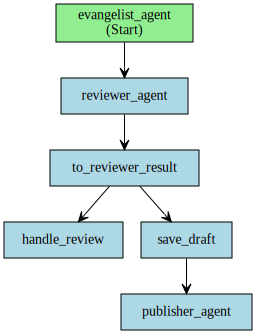

Error occurred: asyncio.run() cannot be called from a running event loop


/tmp/ipykernel_5538/967211894.py:142: RuntimeWarning: coroutine 'Server.serve' was never awaited
  print(f"Error occurred: {e}")


In [ ]:
# Example 4 : Evangelist Review Publish Workflow with conditional branching

EvangelistInstructions = """
You are a technology evangelist create a first draft for a technical tutorials.
1. Each knowledge point in the outline must include a link. Follow the link to access the content related to the knowledge point in the outline. Expand on that content.
2. Each knowledge point must be explained in detail.
3. Rewrite the content according to the entry requirements, including the title, outline, and corresponding content. It is not necessary to follow the outline in full order.
4. The content must be more than 200 words.
4. Output draft as Markdown format. set 'draft_content' to the draft content.
5. return result as JSON with fields 'draft_content' (string).
"""

ContentReviewerInstructions = """
You are a content reviewer for a publishing company. You need to check whether the tutorial's draft content meets the following requirements:

1. The draft content less than 200 words, set 'review_result' to 'No' and 'reason' to 'Content is too short'. If the draft content is more than 200 words, set 'review_result' to 'Yes' and 'reason' to 'The content is good'.
2. set 'draft_content' to the original draft content.
3. return result as JSON with fields 'review_result' (one of Yes, No) and 'reason' (string) and 'draft_content' (string).

"""

PublisherInstructions = """
You are the content publisher ,run code to save the tutorial's draft content as a Markdown file. Saved file's name is marked with current date and time, such as yearmonthdayhourminsec. Note that if it is 1-9, you need to add 0, such as  20240101123045.md. 
"""

class EvangelistAgent(BaseModel):
    draft_content: str

class ReviewAgent(BaseModel):
    review_result: Literal["Yes", "No"]
    reason: str
    draft_content: str

class PublisherAgent(BaseModel):
    file_path: str

@dataclass
class ReviewResult:
    review_result: str
    reason: str
    draft_content: str

@executor(id="to_reviewer_result")
async def to_reviewer_result(response: AgentExecutorResponse, ctx: WorkflowContext[ReviewResult]) -> None:

    print(f"Raw response from reviewer agent: {response.agent_run_response.text}")

    parsed = ReviewAgent.model_validate_json(response.agent_run_response.text)
    await ctx.send_message(
        ReviewResult(
            review_result=parsed.review_result,
            reason=parsed.reason,
            draft_content=parsed.draft_content,
        )
    )


def select_targets(review: ReviewResult, target_ids: list[str]) -> list[str]:
        # Order: [handle_review, submit_to_email_assistant, summarize_email, handle_uncertain]
        handle_review_id, save_draft_id = target_ids
        if review.review_result == "Yes":
            return [save_draft_id]
        else:
            return [handle_review_id]
        


@executor(id="handle_review")
async def handle_review(review: ReviewResult, ctx: WorkflowContext[str]) -> None:
    if review.review_result == "No":
        await ctx.yield_output(f"Review failed: {review.reason}, please revise the draft.")
    else:
        await ctx.send_message(
            AgentExecutorRequest(messages=[ChatMessage(Role.USER, text=review.draft_content)], should_respond=True)
        )


@executor(id="save_draft")
async def save_draft(review: ReviewResult, ctx: WorkflowContext[AgentExecutorRequest]) -> None:
    # Only called for long NotSpam emails by selection_func
    await ctx.send_message(
        AgentExecutorRequest(messages=[ChatMessage(Role.USER, text=review.draft_content)], should_respond=True)
    )


try:
    evangelist_agent = AgentExecutor(chat_client.create_agent(
        instructions= ("EvangelistInstructions"),
        tools=[HostedWebSearchTool()],
        # response_format=EvangelistAgent
    ),  id="evangelist_agent")
    reviewer_agent = AgentExecutor(chat_client.create_agent(
        instructions=(ContentReviewerInstructions),
        # response_format=ReviewAgent
    ), id="reviewer_agent")
    publisher_agent = AgentExecutor(chat_client.create_agent(
        instructions=PublisherInstructions,
        tools=HostedCodeInterpreterTool(),
        response_format=PublisherAgent
    ), id="publisher_agent")

    workflow = (
        WorkflowBuilder()
            .set_start_executor(evangelist_agent)
            .add_edge(evangelist_agent, reviewer_agent)
            .add_edge(reviewer_agent, to_reviewer_result)
            .add_multi_selection_edge_group(
                to_reviewer_result,
                [handle_review, save_draft],
                selection_func=select_targets,
            )
            .add_edge(save_draft, publisher_agent)
            .build()
    )

    print_workflow_viz(workflow, title="Evangelist Review Publish Workflow")
    
    task = """
        You are a evangelist , need to write a  draft based on the following outline and the content provided in the link corresponding to the outline. After draft create , the reviewer check it , if it meets the requirements, it will be submitted to the publisher and save it as a Markdown file, otherwise need to rewrite draft until it meets the requirements.
            The provided outline content and related links is as follows:
        # Introduce AI Agent
        ## What's AI Agent
        https://github.com/microsoft/ai-agents-for-beginners/tree/main/01-intro-to-ai-agents
        ***Note*** Don't create any sample code 

        ## Introduce Azure AI Foundry Agent Service 
        https://learn.microsoft.com/en-us/azure/ai-foundry/agents/overview
        ***Note*** Don's create any sample code 

        ## Microsoft Agent Framework 
        https://github.com/microsoft/agent-framework/tree/main/docs/docs-templates
        ***Note*** Don't create any sample code 
        """
        
    events = await workflow.run(task)
    for i, event in enumerate(events, start=1):
        print_workflow_event(event, index=i)

except Exception as e:
    print(f"Error occurred: {e}")
